#Import 

In [34]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch.optim as optim
from torchvision import transforms, datasets, models
import os

import warnings
warnings.filterwarnings('ignore')

In [35]:
#文件路径
training_folder = 'E:/py/MachineLearing/MachineLearning-CourseExercise/PlantSeedlingsClassification/train'
test_folder = 'E:/py/MachineLearing/MachineLearning-CourseExercise/PlantSeedlingsClassification/test'

In [36]:
def return_classes(parent_folder):
    classes = {}
    for i,plant_type in enumerate(os.listdir(parent_folder)):
        classes.setdefault(i,plant_type)
    return classes

classes = return_classes(training_folder)
classes

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

创建训练集

In [37]:
def create_train_dataframe(parent_folder, classes, verbose=True):
    data = []
    for i,plant_class in classes.items():
        folder = os.path.join(parent_folder,plant_class)
        images = os.listdir(folder)
        for image in images:
            image_path = os.path.join(folder,image)
            data.append([image_path,plant_class,i])
            
    df = pd.DataFrame(data,columns=['image','type','class'], index=np.arange(1,len(data)+1))
    return df


plant_df = create_train_dataframe(training_folder,classes)
print(len(plant_df))
plant_df.head()

4750


,image,type,class
1,E:/py/MachineLearing/MachineLearning-CourseExe...,Black-grass,0
2,E:/py/MachineLearing/MachineLearning-CourseExe...,Black-grass,0
3,E:/py/MachineLearing/MachineLearning-CourseExe...,Black-grass,0
4,E:/py/MachineLearing/MachineLearning-CourseExe...,Black-grass,0
5,E:/py/MachineLearing/MachineLearning-CourseExe...,Black-grass,0


In [38]:
def images_per_class(dataframe):
    img_per_class = []
    for i,plant_type in classes.items():
        total_images = len(dataframe[dataframe['class'] == i])
        img_per_class.append(total_images)
        print(plant_type, total_images)
    return img_per_class

images_per_class(plant_df)

Black-grass 263
Charlock 390
Cleavers 287
Common Chickweed 611
Common wheat 221
Fat Hen 475
Loose Silky-bent 654
Maize 221
Scentless Mayweed 516
Shepherds Purse 231
Small-flowered Cranesbill 496
Sugar beet 385


[263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

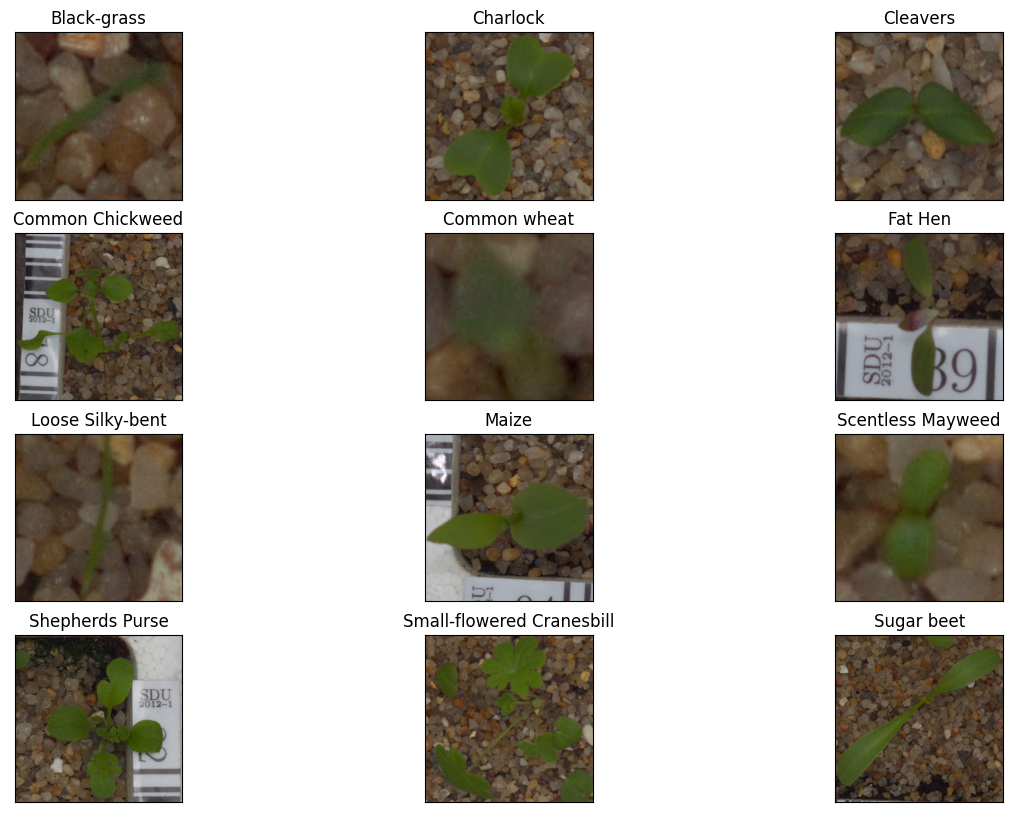

In [39]:
%matplotlib inline
def plot_img_per_class(dataframe):
    plt.figure(figsize=(15,10))
    for i in range(12):
        index = np.random.choice
        images = plant_df[plant_df['class']==i]['image'].values
        index = np.random.choice(len(images))
        image = Image.open(images[index])
        plt.subplot(4,3,i+1)
        plt.imshow(image)
        plt.title(classes[i])
        plt.xticks([])
        plt.yticks([])
        
        
plot_img_per_class(plant_df)

In [40]:
## test train split
#n：抽取的行数 frac：百分比
train_data = plant_df.sample(frac=0.8)
valid_data = plant_df[~plant_df['image'].isin(train_data['image'])]

In [41]:
print(train_data.shape, valid_data.shape)

(3800, 3) (950, 3)


In [42]:
class Plant_Dataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        image_file = self.dataframe.iloc[index,0]
        image = Image.open(image_file).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = self.dataframe.iloc[index,2]
        
        return image, label



In [43]:
plant_dataset = Plant_Dataset(plant_df)

In [44]:
# Resize	把给定的图片resize到given size
# Normalize	用均值和标准差归一化张量图像
# ToTensor	convert a PIL image to tensor (H*W*C) in range [0,255] to a torch.Tensor(C*H*W) in the range [0.0,1.0]
# CenterCrop	在图片的中间区域进行裁剪
# RandomCrop	在一个随机的位置进行裁剪
# FiceCrop	把图像裁剪为四个角和一个中心
# RandomResizedCrop	将PIL图像裁剪成任意大小和纵横比
# ToPILImage	convert a tensor to PIL image
# RandomHorizontalFlip	以0.5的概率水平翻转给定的PIL图像
# RandomVerticalFlip	以0.5的概率竖直翻转给定的PIL图像
# Grayscale	将图像转换为灰度图像
# RandomGrayscale	将图像以一定的概率转换为灰度图像
# ColorJitter	随机改变图像的亮度对比度和饱和度

In [45]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

validation_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

In [46]:
image, label = plant_dataset.__getitem__(1)
train_transform(image)

tensor([[[ 0.0569,  0.1083,  0.1083,  ..., -1.0562, -1.1418, -1.1760],
         [-0.0972,  0.0227,  0.0912,  ..., -1.0904, -1.1418, -1.1760],
         [-0.2342, -0.1828, -0.0801,  ..., -1.0562, -1.1247, -1.1418],
         ...,
         [-0.5253, -0.5082, -0.4739,  ..., -0.7308, -0.7137, -0.6794],
         [-0.4911, -0.4739, -0.4397,  ..., -0.7137, -0.6794, -0.6623],
         [-0.5253, -0.4911, -0.4568,  ..., -0.6452, -0.6623, -0.6623]],

        [[-0.0924,  0.0301,  0.0651,  ..., -1.1253, -1.2129, -1.2479],
         [-0.2500, -0.0399,  0.0651,  ..., -1.1604, -1.1604, -1.1954],
         [-0.3901, -0.3025, -0.1975,  ..., -1.0903, -1.1429, -1.1779],
         ...,
         [-0.6702, -0.6352, -0.6176,  ..., -1.1253, -1.1954, -1.2129],
         [-0.6877, -0.6527, -0.6352,  ..., -1.1078, -1.1253, -1.1604],
         [-0.7752, -0.7052, -0.6702,  ..., -1.0378, -1.0728, -1.1253]],

        [[-0.2010, -0.0615, -0.0615,  ..., -0.9853, -1.0898, -1.1247],
         [-0.3578, -0.1487, -0.0615,  ..., -1

In [47]:
#分别为训练集和测试集设置数据集和数据加载器
datasets =  {}

datasets['train'] = Plant_Dataset(train_data, train_transform)
datasets['validation'] = Plant_Dataset(valid_data, validation_transform)
print(len(datasets['train']))
print(len(datasets['validation']))

3800
950


In [76]:
batch_size=64

dataloaders = {}
dataloaders['train'] = DataLoader(datasets['train'], shuffle=True, batch_size=batch_size)
dataloaders['validation'] = DataLoader(datasets['validation'], shuffle=False, batch_size=batch_size)

In [77]:
dataset_sizes = {}
dataset_sizes['train'] = len(datasets)

In [78]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [79]:
model = models.resnet50(pretrained=True)
# freezing the initial layers
for param in model.parameters(): 
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features,12)
)



In [52]:
"""
在PyTorch中加载模型时,所有参数的'requires_grad''字段默认设置为true。
这意味着对参数值的每一次更改都将被存储,以便在用于训练的反向传播图中使用。这增加了内存需求。
如果预训练的模型中的大多数参数已经训练好了,就将requires_grad字段重置为false。

为了适应自己的数据集,将ResNet-50的最后一层替换为,将原来最后一个全连接层的输入喂给一个有12个输出单元的线性层
#接着再连接ReLU层和Dropout层,然后是12 x 6的线性层,输出为 6 通道的softmax层。
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 6),
    nn.LogSoftmax(dim=1)
"""


'\n在PyTorch中加载模型时，所有参数的‘requires_grad’字段默认设置为true。这意味着对参数值的每一次更改都将被存储，以便在用于训练的反向传播图中使用。这增加了内存需求。由于预训练的模型中的大多数参数已经训练好了，因此将requires_grad字段重置为false。\n\n为了适应自己的数据集，将ResNet-50的最后一层替换为，将原来最后一个全连接层的输入喂给一个有12个输出单元的线性层\n#接着再连接ReLU层和Dropout层，然后是12 x 6的线性层，输出为 6 通道的softmax层。\n    nn.ReLU(),\n    nn.Dropout(0.4),\n    nn.Linear(256, 6),\n    nn.LogSoftmax(dim=1)\n'

In [80]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [81]:
# lr scheduler - reduce on loss plateau decay
# lr = lr * factor 
# 在min模式下,当数量停止减少时,lr将减少,在max模式下,当数量停止增加时,将lr减少
# factor = decaying factor
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5, factor=0.1, verbose=True, mode='max')

ReduceLROnPlateau：这是常用的学习率策略之一。应用本策略时，当特定的度量指标，如训练损失、验证损失或准确率不再变化时，学习率就会改变。通用实践是将学习率的原始值降低为原来的1/2～1/10。

In [82]:
images,labels = next(iter(dataloaders['train']))
images,labels = images.to(device),labels.to(device)
model = model.to(device)
torch.argmax(model(images),dim=1)

tensor([ 3,  5,  3,  0,  0,  3,  5,  0,  4,  0,  3,  0,  4,  0,  4,  0,  3,  4,
         0,  1,  0,  0,  4,  3,  0,  2,  3,  0,  0,  3,  2,  0,  0,  0,  3,  4,
         3,  0,  0,  0,  0,  4,  3,  0,  0,  0,  0,  0,  0,  0,  8,  0,  3,  4,
         3,  3,  3,  5,  3,  3,  3, 10,  0,  0], device='cuda:0')

训练：

In [83]:
def train(model, optimizer, loss_fn, epochs=10, device=device):
    start_time = time.time()
    best_acc = 0
    best_model_wts = model.state_dict()
    
    train_loss = []
    val_loss = []
    
    train_acc = []
    val_acc = []
    
    model = model.to(device)
    for epoch in tqdm(range(epochs)):
        print('Epoch {}/{}'.format(epoch,epochs))
        print('-'*20)
        
        for phase in ['train', 'validation']:
            
            ## 1. setting up the training mode 
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0.0
            running_batch = 0.0
            
            for data in dataloaders[phase]:
                images,labels = data
                images,labels = images.to(device), labels.to(device)
                
                #梯度是累加的,每次清零
                optimizer.zero_grad()

                # forward pass
                output = model(images)
                loss = loss_fn(output,labels)
                preds = torch.argmax(output,dim=1) #计算误差

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 统计
                running_loss += loss.item()
                running_corrects += torch.sum(preds==labels)
                running_batch += 1
            
            epoch_loss = running_loss/running_batch
            if phase == 'train':
                epoch_accuracy = running_corrects/3800
            elif phase == 'validation':
                epoch_accuracy = running_corrects/950

            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_accuracy.cpu().numpy())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy.cpu().numpy())
                # 在验证阶段逐步调整学习率，避免数据集过拟合
                scheduler.step(epoch_accuracy) 
                
            print('{} Loss {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy))
            
            ## save the best model
            if phase == 'validation' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_model_wts = model.state_dict()
                
     
    time_elapsed = time.time() - start_time    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best accuracy {:.4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    

    ## plot the statistics
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, sharex=True)
    ax1.plot(train_loss)
    ax1.plot(val_loss)
    ax1.set_title('Cross Entropy loss')
    ax1.set_xlabel('Epochs')
    
    ax2.plot(train_acc)
    ax2.plot(val_acc)
    ax2.set_title('Accuracy (%)')
    ax2.set_xlabel('Epochs')
    
    return model

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 0/40
--------------------
train Loss 0.3354 Acc: 0.9111


  2%|▎         | 1/40 [00:59<38:29, 59.21s/it]

validation Loss 0.5162 Acc: 0.8263
Epoch 1/40
--------------------
train Loss 0.3352 Acc: 0.9082


  5%|▌         | 2/40 [02:04<39:35, 62.51s/it]

validation Loss 0.5097 Acc: 0.8242
Epoch 2/40
--------------------
train Loss 0.3369 Acc: 0.9074


  8%|▊         | 3/40 [03:07<38:49, 62.97s/it]

validation Loss 0.5040 Acc: 0.8305
Epoch 3/40
--------------------
train Loss 0.3402 Acc: 0.9011


 10%|█         | 4/40 [04:12<38:15, 63.75s/it]

Epoch 00034: reducing learning rate of group 0 to 1.0000e-05.
validation Loss 0.5071 Acc: 0.8232
Epoch 4/40
--------------------
train Loss 0.3346 Acc: 0.9087


 12%|█▎        | 5/40 [05:17<37:32, 64.34s/it]

validation Loss 0.5059 Acc: 0.8347
Epoch 5/40
--------------------
train Loss 0.3289 Acc: 0.9129


 15%|█▌        | 6/40 [06:20<36:10, 63.85s/it]

validation Loss 0.5012 Acc: 0.8326
Epoch 6/40
--------------------
train Loss 0.3320 Acc: 0.9076


 18%|█▊        | 7/40 [07:24<35:01, 63.69s/it]

validation Loss 0.5075 Acc: 0.8347
Epoch 7/40
--------------------
train Loss 0.3309 Acc: 0.9121


 20%|██        | 8/40 [08:25<33:31, 62.87s/it]

validation Loss 0.5090 Acc: 0.8274
Epoch 8/40
--------------------
train Loss 0.3289 Acc: 0.9113


 22%|██▎       | 9/40 [09:29<32:41, 63.26s/it]

validation Loss 0.4990 Acc: 0.8379
Epoch 9/40
--------------------
train Loss 0.3323 Acc: 0.9105


 25%|██▌       | 10/40 [10:35<32:02, 64.07s/it]

validation Loss 0.5066 Acc: 0.8295
Epoch 10/40
--------------------
train Loss 0.3309 Acc: 0.9111


 28%|██▊       | 11/40 [11:40<31:04, 64.30s/it]

validation Loss 0.5057 Acc: 0.8274
Epoch 11/40
--------------------
train Loss 0.3335 Acc: 0.9108


 30%|███       | 12/40 [12:44<30:03, 64.40s/it]

validation Loss 0.5062 Acc: 0.8358
Epoch 12/40
--------------------
train Loss 0.3246 Acc: 0.9129


 32%|███▎      | 13/40 [13:48<28:57, 64.34s/it]

validation Loss 0.5020 Acc: 0.8347
Epoch 13/40
--------------------
train Loss 0.3288 Acc: 0.9105


 35%|███▌      | 14/40 [14:54<28:04, 64.78s/it]

validation Loss 0.5004 Acc: 0.8305
Epoch 14/40
--------------------
train Loss 0.3252 Acc: 0.9132


 38%|███▊      | 15/40 [15:59<26:58, 64.74s/it]

Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.
validation Loss 0.5037 Acc: 0.8295
Epoch 15/40
--------------------
train Loss 0.3407 Acc: 0.9055


 40%|████      | 16/40 [17:04<25:54, 64.75s/it]

validation Loss 0.5026 Acc: 0.8368
Epoch 16/40
--------------------
train Loss 0.3291 Acc: 0.9116


 42%|████▎     | 17/40 [18:08<24:49, 64.76s/it]

validation Loss 0.5052 Acc: 0.8368
Epoch 17/40
--------------------
train Loss 0.3335 Acc: 0.9132


 45%|████▌     | 18/40 [19:13<23:42, 64.65s/it]

validation Loss 0.5062 Acc: 0.8305
Epoch 18/40
--------------------
train Loss 0.3274 Acc: 0.9087


 48%|████▊     | 19/40 [20:17<22:31, 64.38s/it]

validation Loss 0.5048 Acc: 0.8305
Epoch 19/40
--------------------
train Loss 0.3362 Acc: 0.9126


 50%|█████     | 20/40 [21:20<21:23, 64.17s/it]

validation Loss 0.5016 Acc: 0.8274
Epoch 20/40
--------------------
train Loss 0.3299 Acc: 0.9071


 52%|█████▎    | 21/40 [22:24<20:14, 63.92s/it]

Epoch 00051: reducing learning rate of group 0 to 1.0000e-07.
validation Loss 0.5017 Acc: 0.8337
Epoch 21/40
--------------------
train Loss 0.3269 Acc: 0.9145


 55%|█████▌    | 22/40 [23:28<19:14, 64.17s/it]

validation Loss 0.5055 Acc: 0.8347
Epoch 22/40
--------------------
train Loss 0.3271 Acc: 0.9113


 57%|█████▊    | 23/40 [24:31<18:05, 63.86s/it]

validation Loss 0.5058 Acc: 0.8263
Epoch 23/40
--------------------
train Loss 0.3250 Acc: 0.9103


 60%|██████    | 24/40 [25:35<16:59, 63.71s/it]

validation Loss 0.5016 Acc: 0.8389
Epoch 24/40
--------------------
train Loss 0.3337 Acc: 0.9103


 62%|██████▎   | 25/40 [26:38<15:53, 63.60s/it]

validation Loss 0.5060 Acc: 0.8274
Epoch 25/40
--------------------
train Loss 0.3306 Acc: 0.9084


 65%|██████▌   | 26/40 [27:41<14:47, 63.37s/it]

validation Loss 0.5068 Acc: 0.8316
Epoch 26/40
--------------------
train Loss 0.3388 Acc: 0.9087


 68%|██████▊   | 27/40 [28:44<13:42, 63.27s/it]

validation Loss 0.5006 Acc: 0.8274
Epoch 27/40
--------------------
train Loss 0.3248 Acc: 0.9126


 70%|███████   | 28/40 [29:47<12:38, 63.20s/it]

validation Loss 0.5038 Acc: 0.8379
Epoch 28/40
--------------------
train Loss 0.3249 Acc: 0.9168


 72%|███████▎  | 29/40 [30:51<11:36, 63.30s/it]

validation Loss 0.5054 Acc: 0.8263
Epoch 29/40
--------------------
train Loss 0.3325 Acc: 0.9137


 75%|███████▌  | 30/40 [31:55<10:35, 63.57s/it]

Epoch 00060: reducing learning rate of group 0 to 1.0000e-08.
validation Loss 0.5050 Acc: 0.8274
Epoch 30/40
--------------------
train Loss 0.3275 Acc: 0.9124


 78%|███████▊  | 31/40 [32:59<09:32, 63.64s/it]

validation Loss 0.5033 Acc: 0.8305
Epoch 31/40
--------------------
train Loss 0.3328 Acc: 0.9087


 80%|████████  | 32/40 [34:02<08:28, 63.59s/it]

validation Loss 0.5031 Acc: 0.8326
Epoch 32/40
--------------------
train Loss 0.3315 Acc: 0.9132


 82%|████████▎ | 33/40 [35:06<07:25, 63.62s/it]

validation Loss 0.5088 Acc: 0.8211
Epoch 33/40
--------------------
train Loss 0.3297 Acc: 0.9111


 85%|████████▌ | 34/40 [36:09<06:21, 63.60s/it]

validation Loss 0.5022 Acc: 0.8400
Epoch 34/40
--------------------
train Loss 0.3316 Acc: 0.9103


 88%|████████▊ | 35/40 [37:13<05:18, 63.65s/it]

validation Loss 0.5051 Acc: 0.8326
Epoch 35/40
--------------------
train Loss 0.3322 Acc: 0.9124


 90%|█████████ | 36/40 [38:17<04:14, 63.70s/it]

validation Loss 0.5048 Acc: 0.8253
Epoch 36/40
--------------------
train Loss 0.3255 Acc: 0.9108


 92%|█████████▎| 37/40 [39:21<03:11, 63.70s/it]

validation Loss 0.5007 Acc: 0.8347
Epoch 37/40
--------------------
train Loss 0.3358 Acc: 0.9089


 95%|█████████▌| 38/40 [40:24<02:07, 63.75s/it]

validation Loss 0.5042 Acc: 0.8305
Epoch 38/40
--------------------
train Loss 0.3324 Acc: 0.9147


 98%|█████████▊| 39/40 [41:29<01:03, 63.84s/it]

validation Loss 0.5018 Acc: 0.8347
Epoch 39/40
--------------------
train Loss 0.3289 Acc: 0.9132


100%|██████████| 40/40 [42:32<00:00, 63.81s/it]

validation Loss 0.4995 Acc: 0.8316
Training complete in 42m 33s
Best accuracy 0.8400


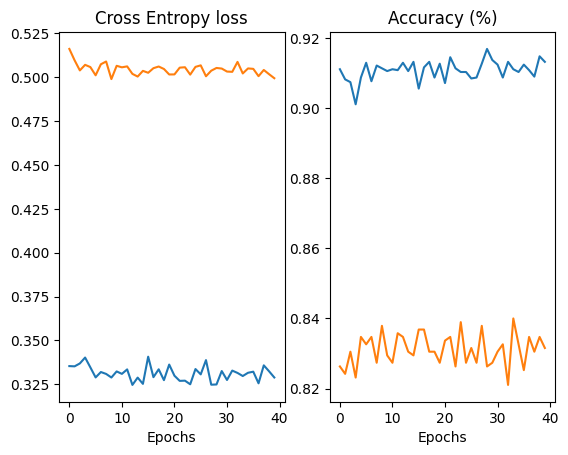

In [94]:
trained_model = train(model,opt, loss_fn, device=device, epochs=40)

In [95]:
# 只保存训练好的权重
state_dict = trained_model.state_dict() 
torch.save(state_dict, 'E:/py/MachineLearing/MachineLearning-CourseExercise/PlantSeedlingsClassification/DeepLearning_model_resnet.pth')

# modelload = models.resnet50()
# modelload = modelload.to(device)
# modelload = modelload.load_state_dict(torch.load(r 'E:/py/MachineLearing/MachineLearning-CourseExercise/PlantSeedlingsClassification/DeepLearning_model_resnet.pth')['model_state_dict'])


In [96]:
images_per_class(valid_data)

Black-grass 51
Charlock 85
Cleavers 50
Common Chickweed 123
Common wheat 46
Fat Hen 100
Loose Silky-bent 125
Maize 44
Scentless Mayweed 93
Shepherds Purse 48
Small-flowered Cranesbill 101
Sugar beet 84


[51, 85, 50, 123, 46, 100, 125, 44, 93, 48, 101, 84]

In [97]:
def plot_confusion_matrix(model, dataloader, device='cpu'):
    y_true = []
    y_preds = []
    model = model.to(device)
    for images,labels in tqdm(dataloader):
        images = images.to(device)
        y_true.extend(labels.numpy())
        with torch.no_grad():
            output = model(images)
            pred = torch.argmax(output,dim=1)
            y_preds.extend(pred.cpu().numpy())

    cm = confusion_matrix(y_true,y_preds)
    df_cm = pd.DataFrame(cm, index=list(classes.values()), columns = list(classes.values()))
    plt.figure(figsize=(10,5))
    ax = sns.heatmap(df_cm, annot=True, fmt='d')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True Labels')
    plt.show()
    
    return cm


In [98]:
def evaluation_statistics(cm):
    for j,plant in tqdm(classes.items()):
        pred_positive_labels = np.sum(cm[:,j])
        true_labels = np.sum(cm[j,:])
        true_positives = cm[j,j]

        precision = true_positives/pred_positive_labels
        recall = true_positives/true_labels
        f_score = 2*precision*recall/(precision+recall)
        accuracy = true_positives/(true_labels+pred_positive_labels-true_positives)

        print('{} | TP = {} | Predicted Yes = {} | True Labels = {}'.format(plant,true_positives, pred_positive_labels, true_labels))
        print('Precision {:.2f}'.format(precision)) # Out of all predicted positive how many are actually correct
        print('Recall {:.2f}'.format(recall)) # True Positive Rate
        print('F_score {:.2f}'.format(f_score))
        print('Accuracy {:.2f}'.format(accuracy)) # True Positive Rate
        print('-'*20)


100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


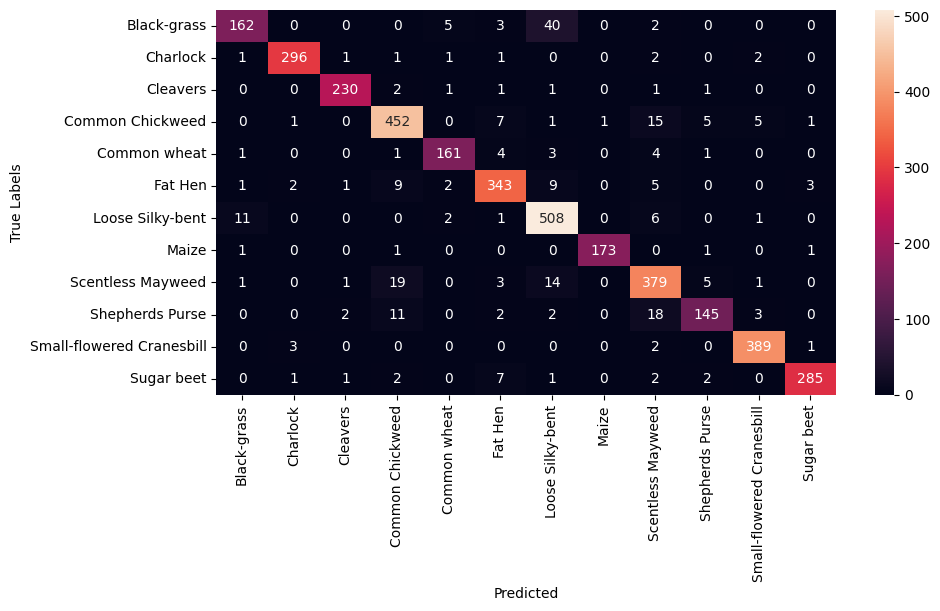

100%|██████████| 12/12 [00:00<00:00, 23552.48it/s]

Black-grass | TP = 162 | Predicted Yes = 178 | True Labels = 212
Precision 0.91
Recall 0.76
F_score 0.83
Accuracy 0.71
--------------------
Charlock | TP = 296 | Predicted Yes = 303 | True Labels = 305
Precision 0.98
Recall 0.97
F_score 0.97
Accuracy 0.95
--------------------
Cleavers | TP = 230 | Predicted Yes = 236 | True Labels = 237
Precision 0.97
Recall 0.97
F_score 0.97
Accuracy 0.95
--------------------
Common Chickweed | TP = 452 | Predicted Yes = 498 | True Labels = 488
Precision 0.91
Recall 0.93
F_score 0.92
Accuracy 0.85
--------------------
Common wheat | TP = 161 | Predicted Yes = 172 | True Labels = 175
Precision 0.94
Recall 0.92
F_score 0.93
Accuracy 0.87
--------------------
Fat Hen | TP = 343 | Predicted Yes = 372 | True Labels = 375
Precision 0.92
Recall 0.91
F_score 0.92
Accuracy 0.85
--------------------
Loose Silky-bent | TP = 508 | Predicted Yes = 579 | True Labels = 529
Precision 0.88
Recall 0.96
F_score 0.92
Accuracy 0.85
--------------------
Maize | TP = 173 | 

In [99]:
# evaluate_data
datasets['train'] = Plant_Dataset(train_data, validation_transform)
train_dataloader= DataLoader(datasets['train'], shuffle=False, batch_size=32)

train_cm = plot_confusion_matrix(trained_model,train_dataloader,device=device)
evaluation_statistics(train_cm)

100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


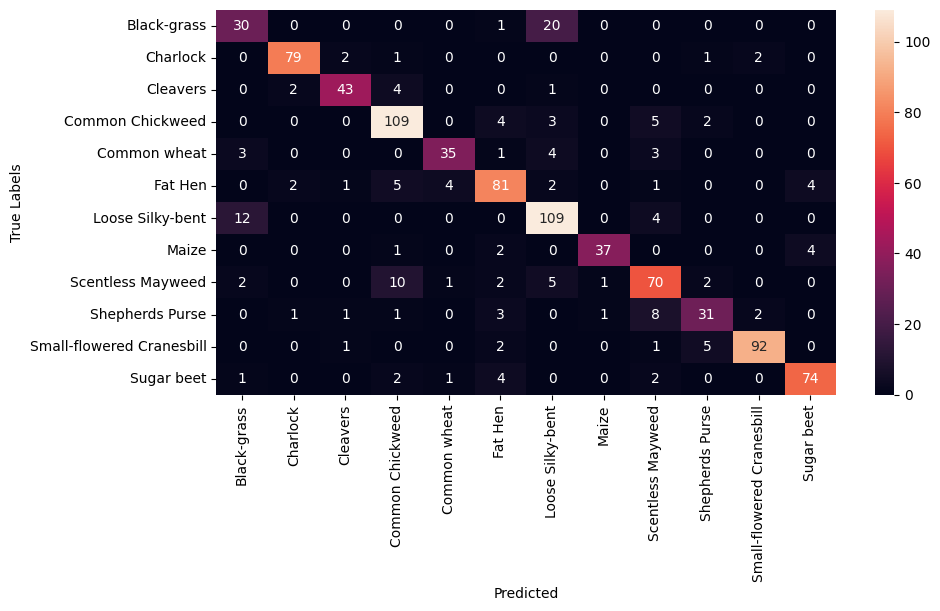

100%|██████████| 12/12 [00:00<00:00, 12032.43it/s]

Black-grass | TP = 30 | Predicted Yes = 48 | True Labels = 51
Precision 0.62
Recall 0.59
F_score 0.61
Accuracy 0.43
--------------------
Charlock | TP = 79 | Predicted Yes = 84 | True Labels = 85
Precision 0.94
Recall 0.93
F_score 0.93
Accuracy 0.88
--------------------
Cleavers | TP = 43 | Predicted Yes = 48 | True Labels = 50
Precision 0.90
Recall 0.86
F_score 0.88
Accuracy 0.78
--------------------
Common Chickweed | TP = 109 | Predicted Yes = 133 | True Labels = 123
Precision 0.82
Recall 0.89
F_score 0.85
Accuracy 0.74
--------------------
Common wheat | TP = 35 | Predicted Yes = 41 | True Labels = 46
Precision 0.85
Recall 0.76
F_score 0.80
Accuracy 0.67
--------------------
Fat Hen | TP = 81 | Predicted Yes = 100 | True Labels = 100
Precision 0.81
Recall 0.81
F_score 0.81
Accuracy 0.68
--------------------
Loose Silky-bent | TP = 109 | Predicted Yes = 144 | True Labels = 125
Precision 0.76
Recall 0.87
F_score 0.81
Accuracy 0.68
--------------------
Maize | TP = 37 | Predicted Yes 

In [100]:
datasets['validation'] = Plant_Dataset(valid_data, validation_transform)
val_dataloader= DataLoader(datasets['validation'], shuffle=False, batch_size=32)

val_cm = plot_confusion_matrix(trained_model,val_dataloader,device=device)
evaluation_statistics(val_cm)

In [101]:
def predict_test_images(folder, model, device='cpu'):
    classification = []
    model = model.to(device)
    for image_file_name in tqdm(os.listdir(folder)):
        image_path = os.path.join(folder,image_file_name)
        image = Image.open(image_path)
        image_input = validation_transform(image).unsqueeze(0).to(device)
        
        ## prediction
        with torch.no_grad():
            output = model(image_input)
            pred = torch.argmax(output,dim=1).item()
            classification.append([image_file_name,classes[pred]])
            
    return classification

In [102]:
test_classification = predict_test_images(test_folder, trained_model, device=device)

100%|██████████| 794/794 [00:12<00:00, 62.59it/s]


In [103]:
submission = pd.DataFrame(np.array(test_classification), columns= ['file','species'], index=np.arange(1,len(test_classification)+1))
submission.head()

submission.to_csv('E:/py/MachineLearing/MachineLearning-CourseExercise/PlantSeedlingsClassification/submission_resnet.csv',index = False)